<img src="../images/5thNRST_logo.png" alt="NOWPAP" width="900" height="700">

## NOWPAP REMOTE SENSING TRAINING COURSE   
#### Webinar 2: Monitoring and Assessment of Water Quality by Ocean Color Remote Sensing
<span style="color:brown; font-size:1.1em;font-style:italic">Time series analysis: data download</span>

<hr style="border:2px solid rgb(30,70,125)"> </hr>

<span style="font-family:Helvieta; font-size:2em;">Genki Terauchi and Eligio Maure </span>

<span style="font-family:Helvieta; font-size:1em;">Please contact terauchi@npec.or.jp for inquiries. </span>

***
**Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

# Table of contents
- [1. Purpose](#1.-Purpose)
- [2. Library import](#2.-Library-import)
- [3. Define parameters](#3.-Define-parameters)
- [4. Trend detection](#4.-Trend-detection)
- [6. Resources](#6.-Resources)
***

# 1. Purpose
[Return to the "Table of contents"](#Table-of-contents)

The objective of this exercise is to learn how to extract the mean of a point or region from a series of satellite images.  
The images used are obtained from the [Marine Environmental Watch](https://ocean.nowpap3.go.jp/?page_id=862) of Northwest Pacific Action Plan (NOWPAP).

***

# 2. Library import
[Return to the "Table of contents"](#Table-of-contents)

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

# System
import sys
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
from matplotlib import colors, ticker

import warnings #Import library to control warning messages
warnings.filterwarnings('ignore') #Import library to control warning messages
%matplotlib inline #For displaying images in jyputer notebook

UsageError: unrecognized arguments: #For displaying images in jyputer notebook


In [2]:
sys.path.append(str(Path('.').absolute().parent)) ##Get current path location
import sutilsx as util #Import NPEC prepared utilities to process and analyze images

util.mpl_custom(mpl=plt) #To let util to specify object for matplib 

# 3. Define parameters
[Return to the "Table of contents"](#Table-of-contents)

In [3]:
# INTPUT_DIR = Path('.').absolute().joinpath(r'data/YOC')
# INPUT_FILE = INTPUT_DIR.joinpath('annual_max_1998_2020.csv')
# YLABEL, XLABEL = 'Chla [mg m$^{-3}$]', 'Day$_{Max}$'

INTPUT_DIR = Path('.').absolute().joinpath(r'data')
INPUT_FILE = INTPUT_DIR.joinpath('ee-chart.csv')
YLABEL, XLABEL = 'chlor_a', 'system:time_start'

# 4. Trend detection
[Return to the "Table of contents"](#Table-of-contents)
- Start with a simple linear trend model

In [4]:
# Read data
df = pd.read_csv(INPUT_FILE)
df.head()

,system:time_start,Trend,chlor_a
0,"Jan 1, 2003",0.667,0.714
1,"Jan 1, 2004",0.693,0.553
2,"Jan 1, 2005",0.731,0.801
3,"Jan 1, 2006",0.741,0.800
4,"Jan 1, 2007",0.765,0.575


<AxesSubplot:xlabel='system:time_start'>

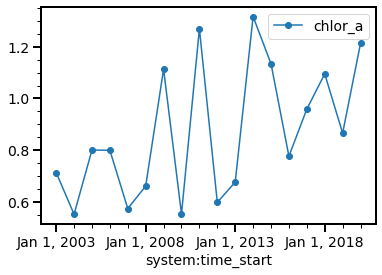

In [5]:
# Display the annual max time series
df['date'] = [d.toordinal() for d in pd.to_datetime(df['system:time_start'])]
df.plot(y=YLABEL, x=XLABEL, marker='o')

- Get the trend and display the result  
Using simple linear simple linear regression we produce the line of best fit

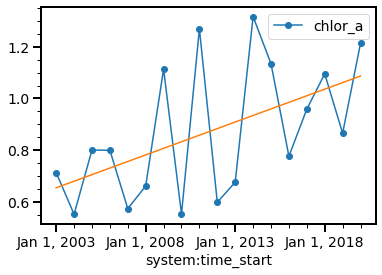

In [6]:
f = np.poly1d(np.polyfit(df['date'], df[YLABEL], 1))
x = np.sort(df['date'])
m, b = f.coeffs
yp = m * x + b

fig, ax = plt.subplots()
df.plot(y=YLABEL, x=XLABEL, marker='o', ax=ax)
ax.plot(df[XLABEL], yp)

#### Now we check the significance of the Regression Slope   
$t_{stat} = \frac{m}{SM} $  

$SM=\frac{S_{yx}} {s_x \sqrt(n-1)}$
> $m:$ slope  
> $SM:$ standard error of the slope

We check whether the slope of our sample differs in a statistically significant way from the theoretical expectation.

In [7]:
result = util.lsq_fity(x=df['date'], y=df[YLABEL], alpha=0.05)

print(f'slope: {result.m:.4f}\nt-statistic: {result.t_stat:.4f}\n'
      f't-critical: {result.t_crit:.4f}\npvalue: {result.p:.4f}')

slope: 0.0001
t-statistic: 2.4446
t-critical: 2.1199
pvalue: 0.0265


[Return to the "Table of contents"](#Table-of-contents)
- Get trend using Sen's slope method
- Sen's slope method uses the Mann-Kendall test to check the significance of detected slope
> The Mann-Kendall Trend Test analyzes difference in signs between earlier and later data points $\frac{n(n – 1)}{2}$.   
> if $n = 8: \frac{8*(8-1)}{2} = 28$, so 28 pairs will be analysed

In [8]:
slope = util.sen_slope(x=df['date'], y=df[YLABEL])
result = util.mktest(x=df['date'], y=df[YLABEL], alpha=0.05)

print(f'slope: {slope:.6f}\nz-score: {result.z_score:.4f}\n'
      f'z-critical: {result.z_crit:.4f}\npvalue: {result.p:.4f}')

slope: 0.000070
z-score: 2.0454
z-critical: 1.9600
pvalue: 0.0102


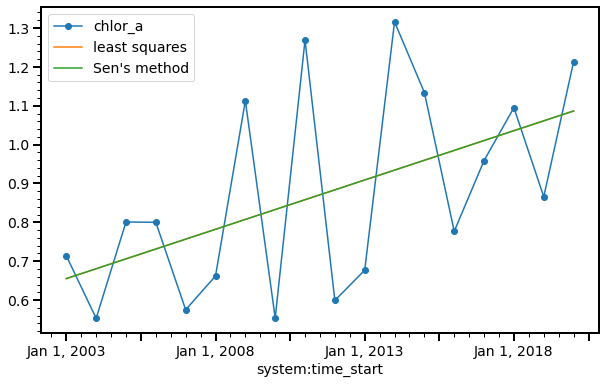

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(y=YLABEL, x=XLABEL, marker='o', ax=ax)

ax.plot(df[XLABEL], yp, label='least squares') # from least squares
ys = result.m * x + result.b
ax.plot(df[XLABEL], ys, label="Sen's method") # from Sen's method
plt.legend()

- Estimate temporal trends for a series of satellite images   
> We use a pre-prepared file with annual max data from 1998 to 2020.   
> You can download the YOC data for the same period and use the methods introduced above to create the same file.

In [10]:
file = INTPUT_DIR.joinpath(r'YOC/month/YOC.1998_2020_amax.nc')
keys = util.get_nc_keys(file=file) # check the key names found in the file
keys

['amax_1998',
 'amaxDay_1998',
 'amax_1999',
 'amaxDay_1999',
 'amax_2000',
 'amaxDay_2000',
 'amax_2001',
 'amaxDay_2001',
 'amax_2002',
 'amaxDay_2002',
 'amax_2003',
 'amaxDay_2003',
 'amax_2004',
 'amaxDay_2004',
 'amax_2005',
 'amaxDay_2005',
 'amax_2006',
 'amaxDay_2006',
 'amax_2007',
 'amaxDay_2007',
 'amax_2008',
 'amaxDay_2008',
 'amax_2009',
 'amaxDay_2009',
 'amax_2010',
 'amaxDay_2010',
 'amax_2011',
 'amaxDay_2011',
 'amax_2012',
 'amaxDay_2012',
 'amax_2013',
 'amaxDay_2013',
 'amax_2014',
 'amaxDay_2014',
 'amax_2015',
 'amaxDay_2015',
 'amax_2016',
 'amaxDay_2016',
 'amax_2017',
 'amaxDay_2017',
 'amax_2018',
 'amaxDay_2018',
 'amax_2019',
 'amaxDay_2019',
 'amax_2020',
 'amaxDay_2020']

In [11]:
import re

In [12]:
xkeys = re.findall('amaxDay.*', '\n'.join(keys)) # separate between data and day of max occurence
ykeys = re.findall('amax_.*', '\n'.join(keys))

In [13]:
%%time
xdata = util.preallocate(file=file, varname=xkeys[0], t=len(xkeys)).astype(np.int64)
ydata = util.preallocate(file=file, varname=ykeys[0], t=len(ykeys))

# load all data
for i, (xkey, ykey, y) in enumerate(zip(xkeys, ykeys, range(1998, 2021))):
    tdata = util.nc_reader(file=file, var=xkey)
    xdata[i, :, :] = tdata + datetime(y, 1, 1).toordinal()
    ydata[i, :, :] = util.nc_reader(file=file, var=ykey)
    
#     print(xdata[i, :, :].min(), end='|')

CPU times: user 1.53 s, sys: 55.3 ms, total: 1.59 s
Wall time: 1.59 s


In [14]:
%%time
# estimate the trends at each pixel location
shape = xdata[0, :, :].shape
slope = np.ma.ones(shape=shape, dtype=np.float32) * -999
slope.mask = True
pval = slope.copy()

t = shape[0] * shape[1]
c = 1

for i in range(shape[0]):
    for j in range(shape[1]):
        c += 1
        
        block = int(50 * c // t)
        bar = '█' * block + '-' * (50 - block)
        print(f'\rRow {i:3} | Col: {j:3} {(100 * c / t):.1f}% |{bar}| {c}/{t}', end='')
        
        check = np.ma.compressed(ydata[:, i, j])
        if check.size == 0:
            continue
            
        x = xdata[:, i, j]
        y = ydata[:, i, j]
        
        msk = x.mask | y.mask
        x = x[~msk].flatten()
        y = y[~msk].flatten()
        
        m = util.sen_slope(x=x, y=y)
        result = util.mktest(x=x, y=y, alpha=0.05)
        if np.isnan(m) or np.isinf(m):
            continue
            
        slope[i, j] = m
        pval[i, j] = result.p
        
print('\nDone!')

Row 165 | Col: 164 100.0% |██████████████████████████████████████████████████| 27391/27390
Done!
CPU times: user 17.2 s, sys: 2.73 s, total: 20 s
Wall time: 19.9 s


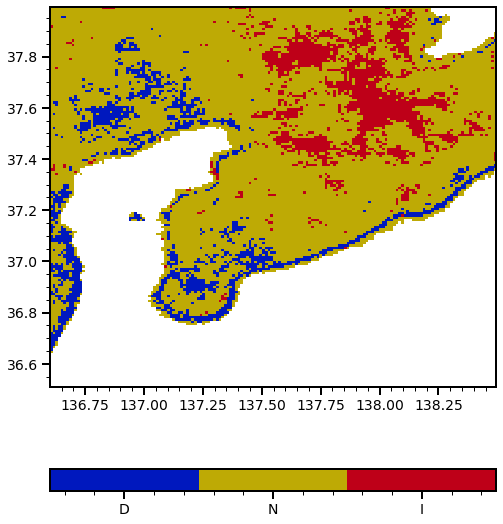

In [15]:
fig, ax = plt.subplots(figsize=(8, 10))

lon = util.nc_reader(file, var='lon')
lat = util.nc_reader(file, var='lat')

# mask non-significant values
mask = pval > 0.05
slp = np.ma.where(slope > 0, 2.5, slope)
slp = np.ma.where(mask | (slp == 0), 1.5, slp)
slp = np.ma.where(slp < 0, 0.5, slp)

# for slope
cmap = util.get_cmap()
bounds = np.linspace(0, 3, 4)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
ms = ax.pcolormesh(lon, lat, slp, cmap=cmap, norm=norm)
cb = plt.colorbar(ms, ax=ax, orientation='horizontal')
cb.set_ticks([0.5, 1.5, 2.5])
cb.set_ticklabels(['D', 'N', 'I'])


<div class="alert alert-block alert-success"/div>
    <b>Done!</b><br>
  
--- 

#### And thank you for your attention! :)
    We hope you enjoyed the training provided by NOWPAP CEARAC.

# 5. Resources
[Go back to the "Table of contents"](#Table-of-contents)

1. https://matplotlib.org/stable/tutorials/advanced/path_tutorial.html
2. https://ocean.nowpap3.go.jp/?page_id=862
3. https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
4. https://up-rs-esp.github.io/mkt/
6. https://github.com/npec/5th-NOWPAP-Training-Course-on-Remote-Sensing-Data-Analysis